# Selection of reservoirs
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 08-11-2024<br>

**Introduction:**<br>
In this notebook I load different reservoir datasets (GloFAS, [GLWD](https://www.sciencedirect.com/science/article/pii/S0022169404001404) and [GRanD](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/100125)), compare them, and select reservoirs from the GRanD dataset that aren't currently included in GloFAS. The objective is to include in GloFAS a representative proportion of the global storage capacity, that [Mulligan et al. (2020)](https://www.nature.com/articles/s41597-020-0362-5) estimate between 7,000 and 8,300 km³.

The final selection of reservoirs for GloFAS5 contains:

1. Reservoirs already included in GloFAS4 (682). 
    * 645 of those reservoirs are associated with a GRanD ID.
    * 37 of those reservoirs are only associated with GLWD (to be checked if they are actually reservoirs).
2. Lakes in GloFAS4 associated with GRanD reservoirs (48).
3. A selection of reservoirs from GRanD (1664) not included in GloFAS4 neither as reservoirs nor lakes. This selection is based on some conditions:
    * Catchment area (`CATCH_SKM`) larger or equal than 500 km2
    * Reservoir storage capacity (`CAP_MCM`) larger or equal than 100 hm3 
    * Reservoirs with a "fair", "good" or "verified" data quality (`QUALITY`)
    * Reservoirs with a status (`TIMELINE`) different than "replaced", "planned", "destroyed" or "under construction"

The total number of reservoirs above adds up to 2391. As this might be an excessively large number, I have created a field named PRIORITY (based on reservoir capacity) that defines the order in which these reservoirs are to be added in GloFAS5:
* 0: reservoirs or lakes in GloFAS4
* 1: reservoirs needed to reach 75% of ghe global storage capacity
* 2: reservoirs needed to reach 80% of ghe global storage capacity
* 3: reservoirs needed to reach 85% of ghe global storage capacity
* 4: the rest

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
import yaml

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import select_reservoirs, filter_reservoirs
from lisfloodreservoirs.utils.plots import plot_reservoir_map

## Configuration

In [2]:
# global reservoir storage capacity, from Mulligan et al. (2020)
total_volume = np.mean([7000, 8300]) * 1000 # hm³

# paths
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets')
PATH_GLOFAS = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_OUT = PATH_DATASETS / 'reservoirs' / 'GloFASv5'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# minimum storage capacity included in EFAS
MIN_VOL = 100 # hm³
MIN_AREA = 500 # km²
MIN_DOR = 0.08 #

## Global Flood Awareness System (GloFAS)
[Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671) defines the criteria used to select reservoirs in GloFAS:

* Reservoirs in GLobal Lakes and Wetlands Database (GLWD) level 1 with a storage capacity equal or larger than 500 hm³.
* Reservoirs in the Global Reservoir and Dam Database (GRanD) with a storage capacity larger than 100 hm³.

I will load two products from GloFAS: a raster with the location and ID of the reservoirs, and a table with the metadata. The raster is only loaded to check that the coordinates in the metadata correspond to the corrected coordinates used in LISFLOOD. To the metadata I will add as new attributes the reservoir tables used in the LISFLOOD simulation, which contain the reservoir parameters: total storage, filling and outflow at different reservoir levels.

### Reservoirs
#### Raster

In [3]:
glofas_raster = xr.open_dataset(PATH_GLOFAS / 'static_maps' / '20220802_reservoirs_Global_03min.nc')['res']

# remove rows/columns with all NaN
aux = glofas_raster.where(~glofas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
glofas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
for id in tqdm(glofas_coords.index):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    glofas_coords.loc[id] = cell.lon.data[0], cell.lat.data[0]
glofas_coords = glofas_coords.round(3)

# # spatial resolution in GloFAS v4
# glofas_pixel = glofas_raster.lon.diff('lon').mean().item()

del aux, glofas_raster

  0%|          | 0/684 [00:00<?, ?it/s]

#### Metadata

In [4]:
# load GloFAS metadata
glofas = pd.read_csv(PATH_GLOFAS / 'tables' / 'GLOFAS_HRES_reservoirs_metadata.csv')
glofas.rename(columns={'ResID': 'RES_ID'}, inplace=True)
glofas.set_index('RES_ID', drop=False, inplace=True)
# keep only those in the reservoir map
glofas = glofas.loc[glofas_coords.index.intersection(glofas.index)]
# convert GLWD_ID to integer
glofas.loc[glofas.Source == 'GranD', 'GLWD_ID'] = np.nan
glofas.GLWD_ID = glofas.GLWD_ID.astype(pd.Int64Dtype())

# create geopandas.GeoDataFrame
glofas = gpd.GeoDataFrame(glofas, geometry=[Point(xy) for xy in zip(glofas.LisfloodX3, glofas.LisfloodY3)])
glofas.crs = 'EPSG:4326'
# glofas.index.name = 'RES_ID'

# # simplify lake name
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.lower()
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.strip()
# glofas.DAM_NAME = glofas.DAM_NAME.str.lower()
# glofas.RIVER = glofas.RIVER.str.lower()

# add attributes from the tables used in LISFLOOD
for file in (PATH_GLOFAS / 'tables').glob('r*.txt'):
    var = file.stem.split('_')[0][1:]
    try:
        df = pd.read_csv(file, sep='\t', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['RES_ID', var]
        df.set_index('RES_ID', inplace=True, drop=True)
        glofas[var] = df
    except:
        print(file)
        continue
# convert storage from m3 to hm³
glofas.stor /= 1e6 
glofas.rename(columns={'stor': 'VOL_GLOFAS'}, inplace=True)

# add catchment area (km2) as attribute
upstream_area = xr.open_dataset(PATH_GLOFAS / 'static_maps' / 'upArea_repaired.nc')['Band1']
for ID, attrs in glofas.iterrows():
    glofas.loc[ID, 'AREA_GLOFAS'] = upstream_area.sel(lat=attrs.LisfloodY3, lon=attrs.LisfloodX3, method='nearest').item() * 1e-6
    
glofas.index.name = 'RES_ID'

print('no. reservoirs in the metadata:\t\t{0}'.format(glofas.shape[0]))
print('no. reservoirs in the raster:\t\t{0}'.format(glofas_coords.shape[0]))
print('reservoirs missing in the metadata:\t{0}'.format(glofas_coords.index.difference(glofas.index).to_list()))
print('reservoirs missing in the raster:\t{0}'.format(glofas.index.difference(glofas_coords.index).to_list()))

no. reservoirs in the metadata:		683
no. reservoirs in the raster:		684
reservoirs missing in the metadata:	[-9999.0]
reservoirs missing in the raster:	[]


* The Therthar lake (Irak) is repeated twice in the raster with ID -9999 and 643. I remove the value -9999.
* There are 2 reservoirs in the metadata that are not in the raster:
    * 361 is Lake Ozark, which is repeated with the ID 362. In the GRanD database there are two consecutive reservoirs in that river, but the reservoir upstream is not in GloFAS. It could be that the chain of reservoirs in GloFAS is the combination of both.
    * 385 is the Kentucky lake, which is repeated with the ID 386. They are actually two different reservoirs in two tributaries just before their confluence. They are both in the GRanD data base, so I have to check if the GloFAS total volume represents the sum of the volume of both reservoirs.
    
The coordinates of the reservoir in the raster are those in the fields _LisfloodX3_ and _LisfloodY3_ in the metadata.

no. reservoirs in GloFAS:		683
total reservoir volume in GloFAS:	4583500 hm³ (59.9%)
no. reservoirs (V > 100 hm³):		681


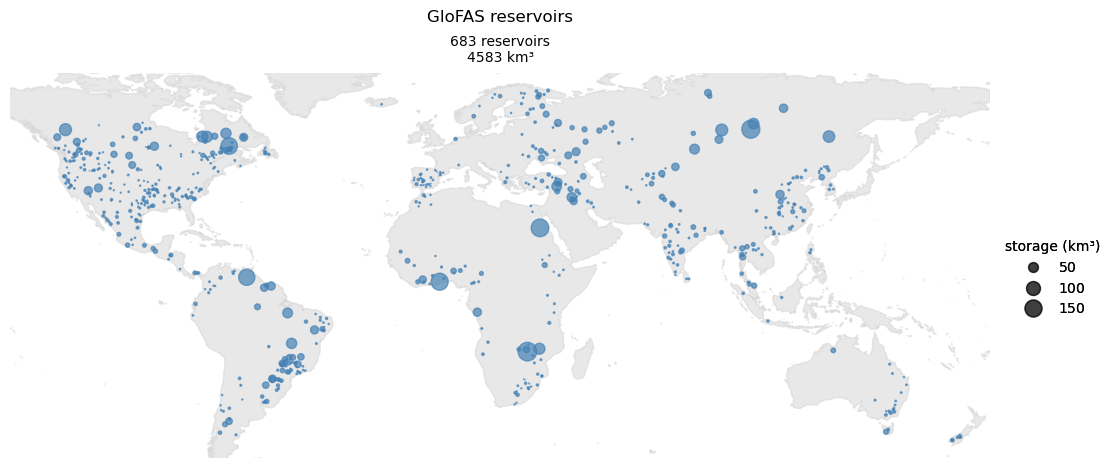

In [5]:
# remove one of the instances of the Therthar lake
glofas_coords.drop(-9999, axis=0, inplace=True, errors='ignore')

# map of GloFAS reservoirs
plot_reservoir_map(
    glofas.geometry,
    glofas.VOL_GLOFAS,
    title='GloFAS reservoirs',
    save=PATH_OUT / 'glofas_reservoirs.jpg'
)

# # map of GloFAS reservoirs
# fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# c = glofas.Source.map({'GLWD': 0, 'GranD': 1}).values
# scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.stor / 1000, cmap='coolwarm', c=c, alpha=.5)
# ax.text(.5, 1.125, 'GloFAS reservoirs', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
# text = '{0} reservoirs\n{1:.0f} km³ ({2:.1f}%)'.format(glofas.shape[0], glofas.stor.sum() / 1000, glofas.stor.sum() / total_volume * 100)
# ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
# ax.axis('off');

# # legend
# handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.5)
# labels1 = ['GLWD', 'GRAND']
# legend1 = ax.legend(handles1, labels1, title='source', bbox_to_anchor=[1.025, .55, .09, .25], frameon=False)
# ax.add_artist(legend1)
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='storage (km³)', bbox_to_anchor=[1.025, .35, .1, .25], frameon=False)
# ax.add_artist(legend2);

# # save
# plt.savefig(PATH_OUT / 'glofas_reservoirs.jpg', dpi=300, bbox_inches='tight')

print('no. reservoirs in GloFAS:\t\t{0}'.format(glofas.shape[0]))
print('total reservoir volume in GloFAS:\t{0:.0f} hm³ ({1:.1f}%)'.format(glofas.VOL_GLOFAS.sum(), glofas.VOL_GLOFAS.sum() / total_volume * 100))
print('no. reservoirs (V > {0} hm³):\t\t{1}'.format(MIN_VOL, (glofas.VOL_GLOFAS >= MIN_VOL).sum()))

***Figure 1**. Reservoirs included in GloFAS. The size of the dots represents the storage capacity. Blue dots are reservoirs whose source is GLWD, whereas the source of red dots is GRanD.*

GloFAS includes **685 reservoirs with a total storage capacity of 4,600 km³ (60% of the global storage capacity)**. 2 of those reservoirs (GloFAS ID 665 and 680) do not comply with the minimum reservoir volume mentioned in Zanja el al. (2017). GLWD is the data source of 650 reservoirs, and only 35 come from the GRanD dataset.

### Lakes 
Some lakes in GloFAS4 are reported as reservoirs in GRanD. I found this by manually inspecting on GIS all lakes in GloFAS4 and compare it with the reservoir polygons in GRanD. I will include these subset of lakes in the selection of reservoirs for GloFAS5.

As it will be needed laker on, I generate here two dictionaries that map the `LakID` in GloFAS4 with GLWD and GRanD, respectively

In [6]:
# load metadata from GloFAS lakes
glofas_lakes = pd.read_csv(PATH_GLOFAS / 'tables' / 'GLOFAS_HRES_lakes_metadata.csv', usecols=['LakID', 'GLWD_ID'], index_col='LakID').squeeze().astype('Int64')
map_lakid_glwd = glofas_lakes.to_dict()

# mapping GloFAS4 lakes and GRanD IDs
with open('lakes_GloFAS4_GRanD.yml', 'r') as file:
    map_lakid_grand = yaml.safe_load(file)

## Global Lakes and Wetlands Database (GLWD)

GLWD is the primary source of information in the reservoirs currently included in GloFAS. The GLWD level 1 product includes polygons of the water bodies (either lakes or reservoirs), from which I will keep only reservoirs. 

no. reservoirs in GLWD:		654
total reservoir volume in GLWD:	4615220 hm³ (60.3%)
no. reservoirs (V > 500 hm³):	654


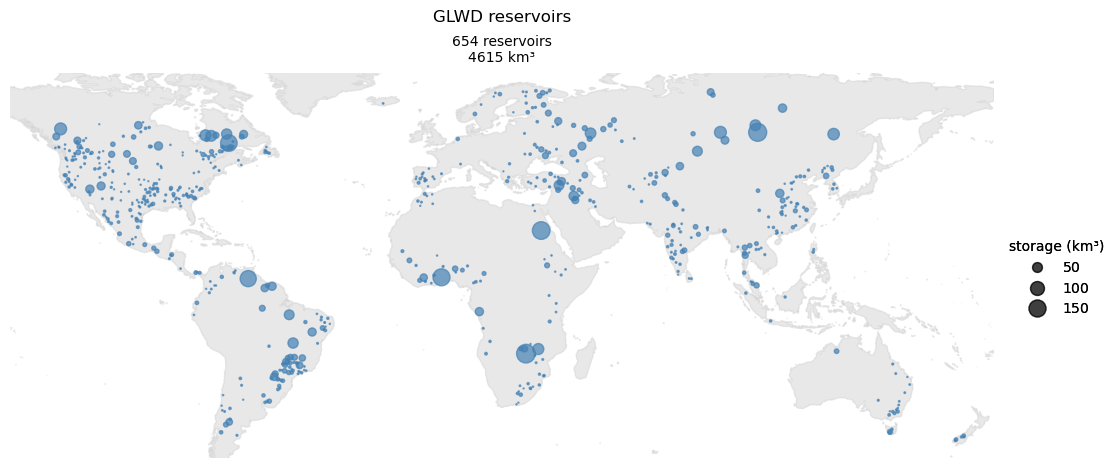

In [7]:
# import data set
path_glwd = PATH_DATASETS / 'lakes' / 'GLWD' / 'level1'
glwd = gpd.read_file(path_glwd / 'glwd_1.shp').set_index('GLWD_ID', drop=False)
glwd.crs = 'EPSG:4326'

# keep only reservoirs
glwd = glwd.loc[glwd.TYPE == 'Reservoir']

# convert reservoir volume to hm³ (million cubic meters)
glwd['VOLUME_MCM'] = glwd.VOLUME_CKM * 1000
glwd.drop('VOLUME_CKM', axis=1, inplace=True)

# convert catchment area to km2
glwd['CATCH_SKM'] = glwd.CATCH_TSKM * 1000
glwd.drop('CATCH_TSKM', axis=1, inplace=True)

# remove empty fields
glwd.dropna(axis=1, how='all', inplace=True)

# convert polygon GeoDataFrame to point GeoDataFrame
glwd = gpd.GeoDataFrame(glwd, geometry=[Point(xy) for xy in zip(glwd.LONG_DEG, glwd.LAT_DEG)])
glwd.crs = 'EPSG:4326'

# # tune lake names in GLWD
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.lower()
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.strip()

plot_reservoir_map(
    glwd.geometry,
    glwd.VOLUME_MCM,
    title='GLWD reservoirs',
    save=PATH_OUT / 'glwd_reservoirs.jpg'
)

print('no. reservoirs in GLWD:\t\t{0}'.format(glwd.shape[0]))
print('total reservoir volume in GLWD:\t{0:.0f} hm³ ({1:.1f}%)'.format(glwd.VOLUME_MCM.sum(), glwd.VOLUME_MCM.sum() / total_volume * 100))
print('no. reservoirs (V > 500 hm³):\t{0}'.format((glwd.VOLUME_MCM >= 500).sum()))

***Figure 2**. Reservoirs in the GLWD data set. The dot size indicates the storage capacity.*

The GLWD data set includes 654 reservoirs, all with a storage capacity larger than 500 hm³. Even if the number of reservoirs in GLWD is smaller than in GloFAS, the total storage capacity of the data set is slightly higher than that of GloFAS. This indicates that some reservoirs in GLWD are not included in GloFAS

In [8]:
# reservoirs in GLWD not included in GloFAS
missing = glwd.index.difference(glofas.GLWD_ID).tolist()
print('{0} reservoirs in GLWD are missing in GloFAS:\t{1}.\nThey account for {2:.0f} hm³ storage capacity.'.format(len(missing), missing, glwd.loc[missing, 'VOLUME_MCM'].sum()))

7 reservoirs in GLWD are missing in GloFAS:	[33, 496, 641, 780, 847, 942, 3359].
They account for 72430 hm³ storage capacity.


647 reservoirs (all but 7) in GLWD are included in GloFAS. However, the field _Source_ in the GloFAS metadata erroneously indicates that 650 reservoirs are from GLWD.

### Compare GLWD and GloFAS4 attributes

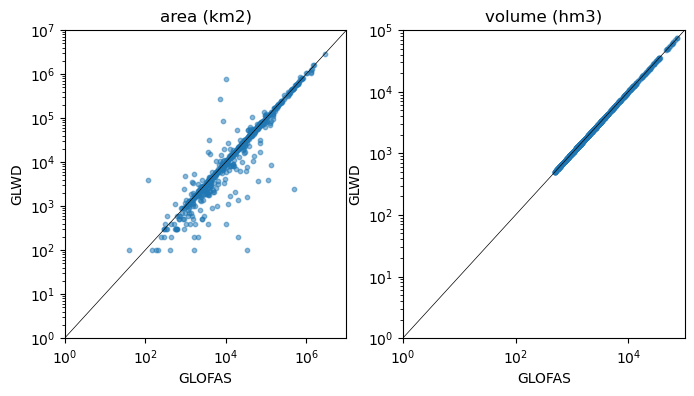

In [9]:
# add coordinates, area and volume from GLWD
cols_GLWD = {'LAT_GLWD': 'LAT_DEG', 'LON_GLWD': 'LONG_DEG', 'AREA_GLWD': 'CATCH_SKM', 'VOL_GLWD': 'VOLUME_MCM'}
glofas[list(cols_GLWD)] = np.nan
glwd_ids = glwd.index.intersection(glofas.GLWD_ID)
for glwd_id in glwd_ids:
    for col_glofas, col_glwd in cols_GLWD.items():
        glofas.loc[glofas.GLWD_ID == glwd_id, col_glofas] = glwd.loc[glwd_id, col_glwd]
glofas[['AREA_GLWD', 'VOL_GLWD']] = glofas[['AREA_GLWD', 'VOL_GLWD']].replace(0, np.nan)

# scatter plots comparing catchment area and storage capacity
src1, src2 = 'GLOFAS', 'GLWD'
variables = {
    'AREA': {'title': 'area (km2)', 'vlim': [1, 1e7]},
    'VOL': {'title': 'volume (hm3)', 'vlim': [1, 1e5]}
}

fig, axes = plt.subplots(ncols=len(variables), figsize=(4 * len(variables), 4))

for ax, var in zip(axes, variables):
    vlim = variables[var]['vlim']
    ax.plot(vlim, vlim, c='k', lw=.5)
    ax.scatter(glofas[f'{var}_{src1}'], glofas[f'{var}_{src2}'], s=10, alpha=.5)
    ax.set(
        xlabel=src1,
        xscale='log',
        xlim=vlim,
        ylabel=src2,
        yscale='log',
        ylim=vlim,
        title=variables[var]['title']
    )

## Global Reservoir and Dam (GRanD)

GloFAS includes 35 reservoirs from the GRanD data set. Figure 1 shows that these reservoirs are located in Spain (23), USA (4), South Africa (4), Canada (2), Togo (1), Brazil (1) and Paraguay (1). I will analyse here the complete GRanD data set to identify possible reservoirs to be added in GloFAS.

GRanD includes both a point shapefile of dams and a polygon shapefile with reservoirs. The amount of reservoirs is slightly smaller than that of dams, but the attributes are the same, so I will use only the dams for the analysis.

GRanD:			7320 reservoirs		6898766 hm³ (90.2%)
GRanD (V >= 100 hm³):	3329 reservoirs		6768537 hm³ (88.5%)


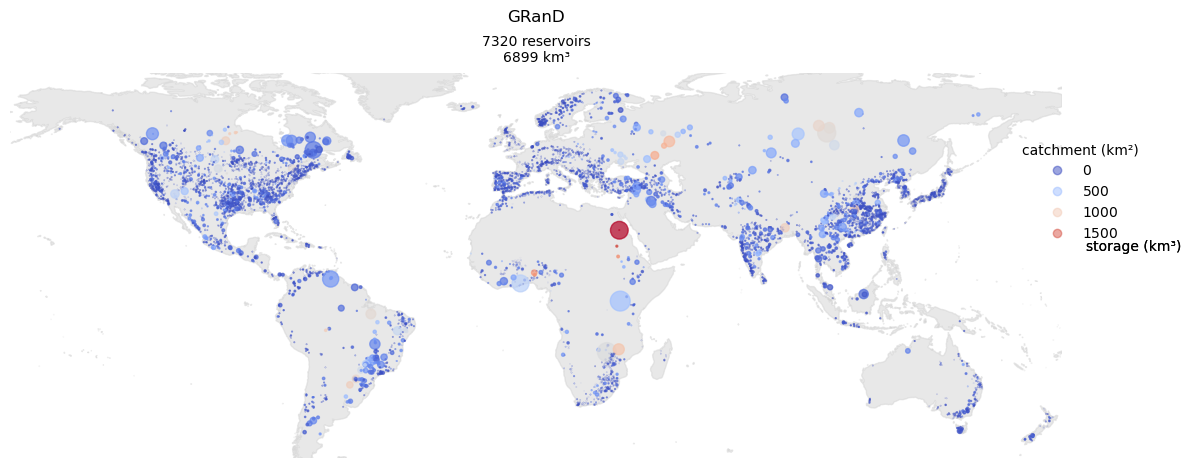

In [10]:
# import data set
path_GRanD = PATH_DATASETS / 'reservoirs' / 'GRanD' / 'v1_3'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp').set_index('GRAND_ID', drop=False)
grand = grand.replace(-99, np.nan)

# # tune lake names in GRanD
# grand.RES_NAME = grand.RES_NAME.str.lower()
# grand.RES_NAME = grand.RES_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# grand.RES_NAME = grand.RES_NAME.str.strip()
# grand.DAM_NAME = grand.DAM_NAME.str.lower()
# grand.RIVER = grand.RIVER.str.lower()

# convert in NaN suspicios values of degree of regulation
grand.DOR_PC = grand.DOR_PC.replace(10000, np.nan)
# compute degree of regulation as in Shrestha et al. (2024)
grand['DOR'] = grand.CAP_MCM / (grand.DIS_AVG_LS * 3600 * 24 * 365 * 1e-9)

plot_reservoir_map(
    grand.geometry,
    grand.CAP_MCM,
    area=grand.CATCH_SKM,
    title='GRanD',
    save=PATH_OUT / 'grand_reservoirs.jpg'
)

grand_volume = grand.CAP_MCM.sum()
print('GRanD:\t\t\t{0} reservoirs\t\t{1:.0f} hm³ ({2:.1f}%)'.format(grand.shape[0], grand_volume, grand_volume / total_volume * 100))
grand_mask_volume = grand.CAP_MCM >= MIN_VOL
grand_volume_sel = grand.loc[grand_mask_volume, 'CAP_MCM'].sum()
print('GRanD (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³ ({3:.1f}%)'.format(MIN_VOL, grand_mask_volume.sum(), grand_volume_sel, grand_volume_sel / total_volume * 100))

***Figure 3**. Dams included in the GRanD data set. The size of the dots represents the storage capacity of the reservoir and the colour the degree of regulation (red for stronger regulation).*

The GRanD data set includes more than 10 times more dams/reservoirs than either GloFAS or GLWD. However, less than a half (3328) of those reservoirs have a capacity of at least 100 hm³. These subset of reservoirs account for 88.2% of the global storage capacity (28.2% more than GloFAS).

Many of the reservoirs in GRanD are already included in GloFAS, but it is not clear since those reservoirs whose source was GLWD (the vast majority) do not include the _GRAND_ID_ field. I have manually checked on GIS matches between GloFAS and GRanD reservoirs, and saved them in a YAML file that I use here to assign `GRAND_ID` to the `glofas`.

In [11]:
glofas.drop([col for col in glofas.columns if 'GRAND' in col.upper()], axis=1, inplace=True)

# read mapping of GloFAS4 reservoirs and GRanD IDs
with open('reservoirs_GloFAS4_GRanD.yml', 'r') as file:
    map_resid_grand = yaml.safe_load(file)
    
# assign GRAND_ID to GloFAS reservoirs 
glofas['GRAND_ID'] = glofas.index.map(map_resid_grand)
glofas.GRAND_ID = glofas.GRAND_ID.astype('Int64')

# add attributes from GRanD
glofas[['AREA_GRAND', 'VOL_GRAND']] = np.nan
for grand_id in grand.index.intersection(glofas.GRAND_ID):
    glofas.loc[glofas.GRAND_ID == grand_id, ['AREA_GRAND', 'VOL_GRAND']] = grand.loc[grand_id, ['CATCH_SKM', 'CAP_MCM']].values

In [12]:
# # find the closest reservoir in GRanD
# for glofas_id in tqdm(glofas.index.difference(map_resid_grand)):
#     # extract info from GloFAS
#     gf_lon, gf_lat = glofas.loc[glofas_id, ['LisfloodX3', 'LisfloodY3']]
#     # compute "distance" from all points in GRanD
#     diff = ((grand.LONG_DD - gf_lon)**2 + (grand.LAT_DD - gf_lat)**2)**.5
#     # find closest
#     if diff.min() <= 5 * glofas_pixel:
#         grand_id = diff.idxmin()
#         map_resid_grand[glofas_id] = grand_id
#             # grand_lake, grand_river = grand.loc[grand_id, ['RES_NAME', 'RIVER']]
#             # if (gf_river == grand_river) | (gf_lake == grand_lake):
#             #     glofas_.loc[id, ['GRAND_ID', 'LAKE_NAME', 'RIVER']] = grand_id, grand_lake, grand_river
#             # glofas.loc[glofas_id, 'GRAND_ID'] = grand_id
#             # grand.loc[grand_id, 'RES_ID'] = glofas_id
#             # attributes = {'LAKE_NAME': 'RES_NAME', 'DAM_NAME': 'DAM_NAME', 'RIVER': 'RIVER'}
#             # for gf_attr, grand_attr in attributes.items():
#             #     if not isinstance(glofas.loc[glofas_id, gf_attr], str):
#             #         glofas.loc[id, gf_attr] = grand.loc[grand_id, grand_attr]

### Compare GRand and GloFAS4 attriutes

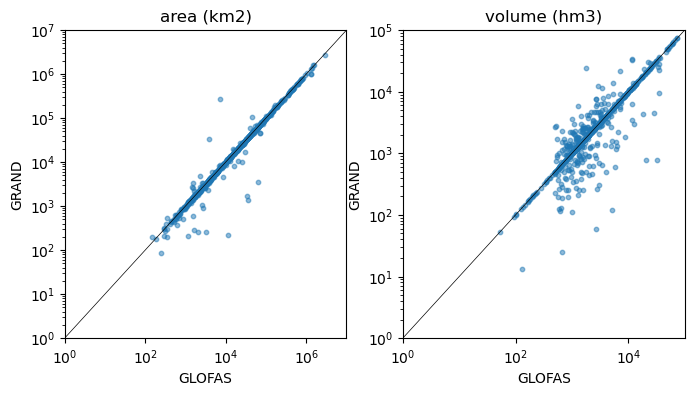

In [13]:
src1, src2 = 'GLOFAS', 'GRAND'
variables = {
    'AREA': {'title': 'area (km2)', 'vlim': [1, 1e7]},
    'VOL': {'title': 'volume (hm3)', 'vlim': [1, 1e5]}
}

fig, axes = plt.subplots(ncols=len(variables), figsize=(4 * len(variables), 4))

for ax, var in zip(axes, variables):
    vlim = variables[var]['vlim']
    ax.plot(vlim, vlim, c='k', lw=.5)
    ax.scatter(glofas[f'{var}_{src1}'], glofas[f'{var}_{src2}'], s=10, alpha=.5)
    ax.set(
        xlabel=src1,
        xscale='log',
        xlim=vlim,
        ylabel=src2,
        yscale='log',
        ylim=vlim,
        title=variables[var]['title']
    )

### Selection of reservoirs

I will keep all reservoirs already in GloFAS and select some from the remaining reservoirs in GRanD. The selection has three steps:

* A filter based on catchment area. `CATCH_SKM` is the catchment area derived from HydroSHEDS and `CATCH_REP` the reported value.
* A filter based on reservoir storage (`CAP_MCM`).
* The field `TIMELINE` includes the state of the reservoir: modified, under construction, replaced, destroyed, planned... I will remove all reservoirs with values 'Replaced', 'Planned', 'Destroyed', 'Under construction'.
* The `QUALITY` field defines how trustworthy is the information. Given the large amount of reservoirs, we could skip those with poor and unreliable quality.
* GRanD includes an estimate of average discharge in the field `DIS_AVG_LS` derived from HydroSHEDS and WaterGAP. It also includes the degree of regulation (field `DOR_PC`), as the ratio between storage capacity (`CAP_MCM`) and the total annual flow (`DIS_AVG_LS`). The degree of regulation could be an interesting characteristic in which to base the final selection of reservoirs.

The concatenation of these two sets of reservoirs --those coming from GloFASv4 and the selection from GRanD-- is the total set of reservoirs to be added in GloFAS5.

There are 2646 reservoirs in GRanD with a capacity larger than 100 hm³ that are not included in GloFAS. They account for a total storage capacity of 2,000 km³, 26% of the global reservoir capacity. 

Since the number of new reservoirs is too large, we need to establish other filters to limit the amount of reservoirs to be included in GloFAS. GRanD includes many attributes that can be useful as filters:

In [14]:
glofas.shape[0], glofas.GLWD_ID.notnull().sum(), glofas.GRAND_ID.notnull().sum(), glofas[['GLWD_ID', 'GRAND_ID']].notnull().all(axis=1).sum()

(683, 647, 646, 610)

**Reservoirs in GloFAS <font color='steelblue'>WITHOUT</font> associated GRanD**

In [15]:
# select those reservoirs from GLWD in GloFAS4 that are not in GRanD
mask = glofas.GRAND_ID.isnull() & glofas.GLWD_ID.notnull()
from_glwd = glofas[mask].copy()
from_glwd.rename(columns={'GLOFAS_ID': 'RES_ID', 'VOL_GLOFAS': 'CAP_MCM', 'AREA_GLOFAS': 'CATCH_SKM', 'LAKE_NAME': 'RES_NAME'}, inplace=True)
print(mask.sum(), 'reservoirs in GloFAS4 are not in GRanD')

37 reservoirs in GloFAS4 are not in GRanD


**Reservoirs and lakes in GloFAS4 <font color='steelblue'>WITH</font> associated GRanD**

In [16]:
# add GLOFAS ResID to grand reservoirs
map_grand_resid = {grand_id: glofas_id for glofas_id, grand_id in map_resid_grand.items() if grand_id is not None}
grand['RES_ID'] = grand.index.map(map_grand_resid)
grand.RES_ID = grand.RES_ID.astype('Int64')
print(grand.RES_ID.notnull().sum(), 'reservoirs in GloFAS4 are in GRanD')

# add GLOFAS LakID to grand reservoirs
map_grand_lakid = {grand_id: lakid for lakid, grand_id in map_lakid_grand.items()}
grand['LAK_ID'] = grand.index.map(map_grand_lakid)
grand.LAK_ID = grand.LAK_ID.astype('Int64')
print(grand.LAK_ID.notnull().sum(), 'lakes in GloFAS4 are in GRanD')

# add GLWD_ID to GRanD reservoirs
map_glofas_glwd = {glofas_id: glwd_id for glofas_id, glwd_id in glofas[glofas.GLWD_ID.notnull()].GLWD_ID.to_dict().items()}
grand['GLWD_ID'] = grand.RES_ID.map(map_glofas_glwd)
grand.GLWD_ID = grand.GLWD_ID.astype('Int64')
print(grand.GLWD_ID.notnull().sum(), 'reservoirs in GRanD, GloFAS and GLWD altogether')

646 reservoirs in GloFAS4 are in GRanD
48 lakes in GloFAS4 are in GRanD
610 reservoirs in GRanD, GloFAS and GLWD altogether


**New reservoirs from GRanD**

In [17]:
# reservoirs or lakes in GloFAS4
mask_in_glofas4 = grand.RES_ID.notnull() | grand.LAK_ID.notnull()

# select reservoirs that fulfil the requirements
mask_conditions = filter_reservoirs(
    grand[~mask_in_glofas4].CATCH_SKM,
    grand[~mask_in_glofas4].CAP_MCM,
    catch_thr=MIN_AREA,
    vol_thr=MIN_VOL
)
grand_new = grand[~mask_in_glofas4 & mask_conditions].copy()

# keep only reservoirs with a fair or higher data quality
mask_quality = grand_new.QUALITY.isin(['3: Fair', '2: Good', '1: Verified'])
print('{0} out of {1} reservoirs have enough data quality'.format(mask_quality.sum(), grand_new.shape[0]))
grand_new = grand_new[mask_quality]
# grand_new.QUALITY.value_counts()

# remove non-existing reservoirs
mask_timeline = grand_new.TIMELINE.isin(['Replaced', 'Planned', 'Destroyed', 'Under construction'])
print('{0} out of {1} reservoirs exist currently'.format((~mask_timeline).sum(), grand_new.shape[0]))
grand_new = grand_new[~mask_timeline]
# grand_new.TIMELINE.value_counts()

2753 out of 6629 reservoirs exceed the minimum catchment area of 500 km2 (0 missing values)
2645 out of 6629 reservoirs exceed the minimum reservoir volume of 100 hm3 (8 missing values)
1794 out of 6629 reservoirs exceed the minimum catchment area (500 km2) and the minimum reservoir volume (100 hm3)
1668 out of 1794 reservoirs have enough data quality
1664 out of 1668 reservoirs exist currently


**Merge**

In [18]:
# concat reservoirs from GloFAS4 and those selected from GRanD
cols = ['GRAND_ID', 'RES_ID', 'LAK_ID', 'GLWD_ID', 'RES_NAME', 'DAM_NAME', 'RIVER', 'CAP_MCM', 'CATCH_SKM', 'geometry']
to_add = pd.concat(
    (
    grand[mask_in_glofas4][cols],
    from_glwd[from_glwd.columns.intersection(cols)],
    grand_new[cols]
    ),
    axis=0
)
to_add.reset_index(drop=True, inplace=True)
to_add.index.name = 'FID'
for source in ['GRAND', 'RES', 'LAK', 'GLWD']:
    col = f'{source}_ID'
    to_add[col] = to_add[col].astype('Int64')
    
# fill in gaps in the GLWD_ID of GloFAS lakes
mask = (to_add.GLWD_ID.isnull() & to_add.LAK_ID.notnull())
to_add.loc[mask, 'GLWD_ID'] = to_add[mask].LAK_ID.map(map_lakid_glwd)
to_add.shape

(2392, 10)

#### Pioritize

I will assign a class called PRIORITY which identifies the order in which reservoirs should be added to GloFAS5:

* 0: those reservoirs coming from GloFAS
* 1: reservoirs needed to reach 75% of the total global storage
* 2: reservoirs needed to reach 80% of the total global storage
* 3: reservoirs needed to reach 85% of the total global storage
* 4: reservoirs needed to reach 90% of the total global storag
* 5: reservoirs needed to reach 95% of the total global storag

In [19]:
to_add.drop('PRIORITY', axis=1, inplace=True, errors='ignore')

# assign priority 0 to reservoirs or lakes in GloFAS4
mask_in_glofas5 = to_add.RES_ID.notnull() | to_add.LAK_ID.notnull()
to_add.loc[mask_in_glofas5, 'PRIORITY'] = 0
glofas_volume = to_add.loc[mask_in_glofas5, 'CAP_MCM'].sum()
print('GloFAS4 reservoirs and lakes ({0}) represent {1:.0f}% of the global storage capacity'.format(mask_in_glofas5.sum(), glofas_volume / total_volume * 100))

priorities = {
    6: 1.,
    5: .95,
    4: .9,
    3: .85,
    2: .8,
    1: .75
}
for priority, proportion in priorities.items():
    
    # storage capacity to be added in GloFAS to reach the target
    target_volume = proportion * total_volume - glofas_volume

    selection = select_reservoirs(
        to_add[~mask_in_glofas5], 
        sort='CAP_MCM', 
        storage='CAP_MCM', 
        target=target_volume,
        plot=False
    )
    to_add.loc[selection.index, 'PRIORITY'] = priority
to_add.PRIORITY = to_add.PRIORITY.astype(int)
print(to_add.PRIORITY.value_counts().sort_index().cumsum())

GloFAS4 reservoirs and lakes (728) represent 65% of the global storage capacity
0     728
1     794
2     989
3    1737
4    2392
Name: PRIORITY, dtype: int64


#### Export

In [20]:
sort_cols = ['FID', 'RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'RES_NAME', 'DAM_NAME', 'RIVER', 'CAP_MCM', 'CATCH_SKM', 'PRIORITY', 'geometry']
to_add.reset_index()[sort_cols].to_file(PATH_OUT / 'reservoirs_glofas5.shp', index=False)